TODO:
1. Get rid of the previous structure relying on calllbacks to process the dataset (Done)
2. 
3. load_autoregressive_traintestsplit: load multiple resolutions

In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO, TFNO

from neuralop import Trainer
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
from neuralop.datasets import load_autoregressive_traintestsplit_v1

device = 'cuda'

path = "./data"
data_path = str(path) + "/ns_random_forces_1.h5"
# path = "../data/ns_contextual"
# data_path = str(path) + "/ns_random_forces.h5"
train_loader, test_loader = load_autoregressive_traintestsplit_v1(
    data_path,
    n_train=180, n_test=20,
    batch_size=32, test_batch_size=128,
    train_subsample_rate=4, test_subsample_rate=4,
    time_step=1,
    predict_feature='u',
)

/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
test_loader.dataset[0]['x'].shape[0]

64

In [2]:
# We create a tensorized FNO model
input_prods = None
n_modes=21
model = FNO(in_channels=5, n_modes=(n_modes, n_modes), hidden_channels=32, 
             projection_channels=64, factorization='tucker', rank=0.1,
             n_layers=16
             )
# model = FNO(in_channels=5, n_modes=(n_modes, [0]n_modes), hidden_channels=32, 
#              projection_channels=64, channel_mixing="prod-layer",
#              factorization='tucker', rank=0.1,
#              n_layers=16
#              )

# width=20; num_prod=3
# model = ProdFNO_2D(in_dim=1, appended_dim=4, out_dim=1,
#                modes1=num_modes, modes2=num_modes, width=width, num_prod=num_prod, input_prods=input_prods)
# model = ProdFNO(in_channels=5, n_modes=(n_modes, n_modes), hidden_channels=32, 
#              projection_channels=64, factorization='tucker', rank=0.42)

model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 567265 parameters.


In [3]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3, 
                                weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (fno_blocks): FNOBlocks1(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-31): 32 x ComplexTuckerTensor(shape=(32, 32, 10, 10), rank=(17, 17, 5, 5))
      )
    )
    (fno_skips): ModuleList(
      (0-15): 16 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(5, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.t

In [4]:
import time
localtime = time.localtime(time.time())
time_now = f"{localtime.tm_mon}-{localtime.tm_mday}-{localtime.tm_hour}-{localtime.tm_min}"

In [5]:
from neuralop.training import SimpleTensorBoardLoggerCallback
from scripts.ns_contextual_trainer import ns_contextual_trainer

trainer = ns_contextual_trainer(model=model, n_epochs=300,
                  device=device,
                  simaug_test_data=False,
                  simaug_train_data=True,
                  callbacks=[SimpleTensorBoardLoggerCallback(log_dir='runs/exp_test1_'+time_now,)],
                  scaling_ks=[4,16], scaling_ps=[4,16],
                  wandb_log=False,
                  log_test_interval=1,
                  use_distributed=False,
                  verbose=True)

2024-04-06 23:10:12.169063: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 23:10:12.190014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 23:10:12.190035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 23:10:12.190557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 23:10:12.194079: I tensorflow/core/platform/cpu_feature_guar

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [6]:
trainer.train(train_loader=train_loader,
              test_loaders={64: test_loader},
              optimizer=optimizer, 
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss, 
              eval_losses=eval_losses)

Training on 36000 samples
Testing on [4000] samples         on resolutions [64].
default: item['x'].shape=torch.Size([32, 5, 64, 64]), len: 36000, len: 200, N: 180
dt*=k_4: item['x'].shape=torch.Size([32, 5, 64, 64]), len: 36000, len: 200, N: 180
dt*=k_16: item['x'].shape=torch.Size([32, 5, 64, 64]), len: 36000, len: 200, N: 180
dt/=p_4: item['x'].shape=torch.Size([32, 5, 64, 64]), len: 35460, len: 197, N: 180
dt/=p_16: item['x'].shape=torch.Size([32, 5, 64, 64]), len: 33300, len: 185, N: 180
64: item['x'].shape=torch.Size([128, 5, 64, 64]), len: 4000, len: 200, N: 20
Raw outputs of size out.shape=torch.Size([32, 1, 64, 64])
test_set:  64 0.15018558502197266 {'64_h1': 0.5503604788780212, '64_l2': 0.28802536511421206}
[0] time=28.67, avg_loss=0.0597, train_err=0.0005, 64_h1=0.5504, 64_l2=0.2880
test_set:  64 0.14188504219055176 {'64_h1': 0.3483776664733887, '64_l2': 0.11787779712677002}
[1] time=27.81, avg_loss=0.0394, train_err=0.0003, 64_h1=0.3484, 64_l2=0.1179
test_set:  64 0.1418893

: 

In [16]:
torch.save(trainer.model, "./ckpt/TFNO_ep300.pth")

/tmp/ipykernel_13037/1837442807.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


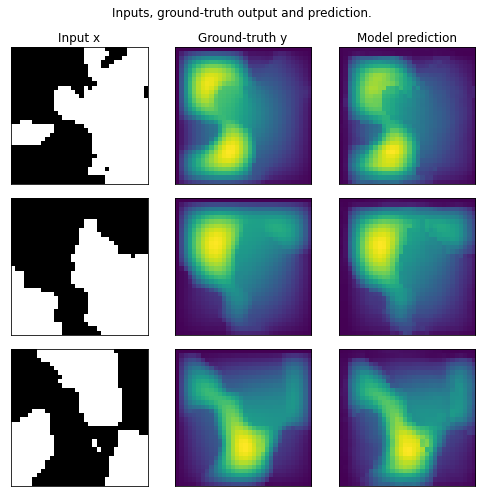

In [8]:
test_samples = test_loader.dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()